In [1]:
import cv2
import numpy as np
import itertools
from matplotlib import pyplot as plt

# Find convolution of 2 shape

In [5]:
def getMask(mask_path):
    # path to mask image
    mask = cv2.imread(mask_path,0)
    mask_position=set()
    for row, value in enumerate(mask):
        for column, element in enumerate(value):
            if element == 255:
                mask_position.add((column,row))
    return mask_position

def getBbox(bbox):
    x,y,x_plus_w,y_plus_h = bbox 
    vehicle_position = itertools.product(range(x,x_plus_w+1),range(y,y_plus_h+1))
    return set(vehicle_position)

def getProbability2Shape(vehicle, mask):
    match = len(vehicle)-len(vehicle.difference(mask))
    bbox  = len(vehicle)
    return (match*100)/bbox

'''
Just a mark for myself
'''
def get_output_layers(net):
    '''
    get all output layer names: with yolov3 is yolo_82, 94 and 106
    ''' 
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidences, x, y, x_plus_w, y_plus_h):
    '''
    draw a bounding box around object
    '''
    label = str(classes[class_id])

    color = COLORS[class_id]
    
#     print(x,y,x_plus_w,y_plus_h)
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def bounding_pic(net, image, scale, size,mask):
    '''
    net: the model reading by open-cv (maybe YoLo or SSD)
    image: image need to bouding box
    scale: image pixel multiply with this
    size: a tuple contain size of image
    '''
    Width = image.shape[1]
    Height = image.shape[0]
    # Resize picture to 416x416, because YOLO take in 416x416
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)
    # set input is resized picture
    net.setInput(blob)
    # last layer of Yolo model
    outs = net.forward(get_output_layers(net))

    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.6
    # maybe our model will detect many bouding box for an object, this threshold help us take the box with equal 
    #            or higher propability
    nms_threshold = 0.4

    '''
    out is a 2D tensor like (number_of_objects, score_of_each_classes), with first five element in each row is special, 
    take e.g: out[0] = temp:
        + temp[0]: x_center of that object
        + temp[1]: y_center of that object
        + temp[2]: width of that object
        + temp[3]: height of that object
        + temp[4]: unknow value
        + from 5 to above is the score of that object to each classes => COCO have 80 class so each row contain 85 element,
            will be 15 with CIFAR,and 1005 with IMAGENET  
    '''
    for out in outs:
        for detection in out:
            scores = detection[5:]
            # get the highest score to determine its label
            class_id = np.argmax(scores)
            if class_id not in [0,1,2,3,7]:
                continue
            else:
                # score of that object, make sure more than 50% correct label
                confidence = scores[class_id]
                if confidence > 0.5:
                    # scale again with w and h
                    center_x = int(detection[0] * Width)
                    center_y = int(detection[1] * Height)
                    w = int(detection[2] * Width)
                    h = int(detection[3] * Height)
                    # remember it return x_center and y_center, not x,y, so we need to find x,y
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])

    # detect bouding box around objects
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    # set the counting line
    lineThickness = 2
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = round(box[0])
        y = round(box[1])
        w = round(box[2])
        h = round(box[3])
        draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
        bbox = getBbox((x,y,x+w,y+h))
        print(len(bbox), len(mask))
        conv = getProbability2Shape(bbox,mask)
        text1 = 'Convolution: ' + str(round(conv,2)) + '%'
        text2 = 'True' if conv > 80 else 'False'
        cv2.putText(image, text1, (x, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5)
        cv2.putText(image, 'Fault: '+text2, (x, y+30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5)
    return image

In [6]:
config = 'YOLOv3-416\\yolov3.cfg'
name = 'YOLOv3-416\\coco.names'
weight = 'YOLOv3-416\\yolov3.weights'
mask_path = './mask.jpg'
import time
classes = None

with open(name, 'r') as f:
    # generate all classes of COCO, bicycle ind = 1, car ind = 2 and motorbike ind = 3
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# Read the model
net = cv2.dnn.readNet(weight, config)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
# take shape of image in order to scale it to 416x416, first layer of Yolo CNN

scale = 0.00392

cap = cv2.VideoCapture('Z:\\Vehicle speed measuring\\video_speed measure\\front.avi')
'''
If output is not None
'''
fourcc = cv2.VideoWriter_fourcc(*'XVID')
outputVideo = cv2.VideoWriter('C:/Users/ADMINS/Desktop/areaResult.avi', fourcc, 20, (1920,1080))

#close

frameNo = 0
count = 0
t1 = time.time()

# for session_0_center
mask = getMask(mask_path)


while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    thresh = 1
    frameNo += 1

    if count%thresh==0:
        # Our operations on the frame come here
        img = bounding_pic(net, frame, scale, (416,416),mask)
        #510,496 1200,471 1527,616 706,749
        
        img = cv2.line(img, (510,496), (1200,471), (255,0,0), 3)
        img = cv2.line(img, (1200,471), (1527,616), (255,0,0), 3)
        img = cv2.line(img, (1527,616), (706,749), (255,0,0), 3)
        img = cv2.line(img, (706,749), (510,496), (255,0,0), 3)
        t2 = time.time()
        fps = round(frameNo/(t2-t1),2)
        img = cv2.putText(img, str(fps), (30, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5)
        cv2.namedWindow('image',cv2.WINDOW_NORMAL)
        cv2.resizeWindow('image', 800,600)
        cv2.imshow('image',img)
        outputVideo.write(frame)
    
    count += 1
    if count == thresh*30:
        count = 0
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
outputVideo.release()
cv2.destroyAllWindows()

6480 166172
1989 166172
3402 166172
1026 166172
640 166172
924 166172
5368 166172
6480 166172
2268 166172
3264 166172
1170 166172
980 166172
680 166172
5280 166172
6408 166172
2184 166172
3520 166172
999 166172
1036 166172
627 166172
5280 166172
6408 166172
2352 166172
3575 166172
1092 166172
850 166172
486 166172
5280 166172
6408 166172
1260 166172
3456 166172
2337 166172
792 166172
504 166172
5280 166172
6408 166172
3286 166172
2419 166172
1488 166172
945 166172
551 166172
5280 166172
6408 166172
2646 166172
3180 166172
1290 166172
918 166172
660 166172
5280 166172
6408 166172
2814 166172
3276 166172
1334 166172
620 166172
825 166172
5280 166172
6408 166172
2706 166172
3472 166172
660 166172
1530 166172
800 166172
5280 166172
6408 166172
3685 166172
1872 166172
1566 166172
660 166172
667 166172
5280 166172
6408 166172
3819 166172
2204 166172
680 166172
1530 166172
4248 166172
5280 166172
2400 166172
3795 166172
6408 166172
814 166172
1537 166172
621 166172
6962 166172
5280 166172
246

# Find the position of vehicle

In [26]:
import numpy as np
def distanceFromPoint2Line(p, line):
    a,b,c = line[0],line[1],line[2]
    try:
        # if list or np.array shape 1
        x,y = p[0],p[1]
    except:
        # if np.array shape 2
        x,y = p[0][0], p[0][1]
    finally:
        top = abs(a*x+b*y+c)
        bottom = np.linalg.norm(np.array([a,b]))
        return top/bottom

def cosineVetorPhase(v1,v2):
    dotProduct = np.dot(v1,v2)
    normV1 = np.linalg.norm(v1)
    normV2 = np.linalg.norm(v2)
    return dotProduct/(normV1*normV2)

def checkSameSideNormalVector(p, line):
    # p is numpy array with shape [1,3] with the final element is 1
    # line is something like ax+by+c = 0, line =[a,b,c]
    return (line[0]*p[0]+line[1]*p[1]+c) > 0


# SYSTEM

In [1]:
from yolo import *
# from tracking import *
from vehicle import *

Using TensorFlow backend.


In [2]:
yolo = Yolo(score = 0.3, iou = 0.45)


YOLOv3-416/yolo.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
from sort import *
from utils import *
from vehicle import *
# from cross_red_line import *


from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

import os
import utilities
import numpy as np
import cv2

import time

def bbox2necess(image, bbox,frame,shape):
    """
    return a list, each element is a list contain [posX,posY,ID,frame_no, image bbox]
    """
    final_res=[]
    width = shape[0]
    height = shape[1]
#     print(width,height)
    for box in bbox:
#         print(box)
        x = int(round(box[0]))
        y = int(round(box[1]))
        w = int(round(box[2]-box[0]))
        h = int(round(box[3]))-int(round(box[1]))
#         print(x,y,w,h)
        x_plus_w = x + w
        y_plus_h = y + h
        bbox2d = image[x:x_plus_w,y:y_plus_h]
        x_centroid = x + w/2
        y_centroid = y + h/2
        bbox2d_position = (y ,x, y_plus_h, x_plus_w)
        res=[x_centroid,y_centroid,(box[4]), frame, bbox2d, bbox2d_position]
        final_res.append(res)
    return final_res


def detect_video(yolo, video_type, video_path, output_path, mask_path, mode, 
                    scale, vp1, vp2, pp, allow_speed, best_performance_line,
                    deadline4Red, allow_lanes, all_lanes, thresh_frame):
    '''
    - Input:
        + yolo: yolo model
        + video_type: 'local' when use video in PC and 'stream' for....stream
        + video_path: path of video
        + output_path: write down if u wanna something more clearly
    - Output:
        + A tensor [x,y,ID,frame_num]
    '''
    # these thing should append into data file
    tuple_cam = computeCameraCalibration(vp1,vp2,pp)
    # t1 = time.time()
    # show for debug
    
#     cv2.namedWindow('image',cv2.WINDOW_NORMAL)
#     cv2.resizeWindow('image', 1000,600)

    
    
    
    
    # require opencv 3.2
    
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    if video_type == 'stream':
        fps = vid.get(cv2.CAP_PROP_FPS)
    elif video_type == 'local':
        fps = vid.get(5)
    # get(7) is all number of frame in video
    # get(5) is get fps, fuck
    
    video_FourCC = cv2.VideoWriter_fourcc('M','J','P','G')
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
#     print(video_size)
    isOutput = True if output_path != "" else False
    if isOutput:
#         print("!!! TYPE:", type(output_path), type(video_FourCC), type(fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, fps, video_size, 1)

    tracker=Sort()
    frame_num=0
    all_vehicle={}
    ignore_set = set()

    mask = getMask(mask_path)
    capture_light = True
    # print(mask)
    t1 = time.time()
    while True:
        

        return_value, pic = vid.read()
        if not return_value:
            break
        image = Image.fromarray(pic)
        if frame_num%thresh_frame==0:
            if yolo.model_image_size != (None, None):
                assert yolo.model_image_size[0]%32 == 0, 'Multiples of 32 required'
                assert yolo.model_image_size[1]%32 == 0, 'Multiples of 32 required'
                boxed_image = letterbox_image(image, tuple(reversed(yolo.model_image_size)))
            else:
                new_image_size = (image.width - (image.width % 32),
                                image.height - (image.height % 32))
                boxed_image = letterbox_image(image, new_image_size)
            image_data = np.array(boxed_image, dtype='float32')
            image_data /= 255.
            image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
            
            # detect for bbox right here

            out_boxes, out_scores, out_classes = yolo.sess.run( 
                [yolo.boxes, yolo.scores, yolo.classes],  
                feed_dict={
                    yolo.yolo_model.input: image_data,
                    yolo.input_image_shape: [image.size[1], image.size[0]],
                    K.learning_phase(): 0
                })
            final_box=[]
            label=[]
            scores=[]
            for b,lb,sc in zip(out_boxes,out_classes,out_scores):
                if lb in [2,3,5,7]:
                    final_box.append(b)
                    label.append(lb)
                    scores.append(sc)
                if lb == 9 and mode == 'crossRedLine' and capture_light:
                    # print this line to debug
                    # capture the light for new agorithm 
                    # append new mask into test image
                    # check photoshop app
                    # check for 
                    # traffic_bbox.append(b)
                    # traffic_score.append(sc)
                    t_x, t_y, b_x, b_y = np.int_(np.round(np.array(b)))
#                     traffic_bbox = pic[t_x:b_x, t_y:b_y, :]
#                     cv2.imwrite('C:/Users/ADMINS/Desktop/light.jpg', traffic_bbox)
                    capture_light = False


            out_boxes=np.array(final_box)
            # out_classes=np.array(label)
            out_scores=np.array(scores)
            final_boxes=np.column_stack((out_boxes,out_scores))
            # print(final_boxes)
            # break
            final_boxes = final_boxes[np.logical_and(final_boxes[:, 4] > 0.3, final_boxes[:, 2] -
                                                        final_boxes[:, 0] < 600)]

                # Apply NMS
            indices = utilities.non_max_suppression(final_boxes, 0.9, final_boxes[:, 4])
            
            # if mode == 'crossRedLine' and capture_light:
            #     traffic_bbox = np.array(traffic_bbox)
            #     print(traffic_bbox)

            #     traffic_score = np.array(traffic_score)
            #     final_traffic = np.column_stack((traffic_bbox,traffic_score))
            #     final_traffic = final_traffic[np.logical_and(final_traffic[:, 4] > 0.3, final_traffic[:, 2] -
            #                                             final_traffic[:, 0] < 600)]
            #     traffic_bbox =  utilities.non_max_suppression(final_traffic, 0.9, final_traffic[:, 4])
            #     break
            

            out_boxes = [final_boxes[i] for i in indices]
            # out_classes= [out_classes[i] for i in indices]
            # rev=(reversed(out_classes))  # for display in order since yolo reverse the list 
            # out_classes=[]
            # for r in rev:
            #     out_classes.append(r)
            # out_classes=np.array(out_classes)
            # bf=out_boxes
            res_track=tracker.update(np.array(out_boxes))
            # res_track return [x,y, x+w, x+y, ID]
            one_frame = bbox2necess(image = pic, bbox = res_track,frame =frame_num,
                                        shape = video_size)
            if mode == 'crossRedLine':
                try:
                    traffic_bbox = pic[t_x:b_x, t_y:b_y, :]
                    traffic_status = detect_red(traffic_bbox)
                    if traffic_status:
                        text_traffic = 'Red'
                        
                    else:
                        text_traffic = 'Green'
                except:
                    print('can not find traffic light')
                    break
            for vehicle in one_frame:
                ID =  int(round(vehicle[2]))
                centroid = [vehicle[0],vehicle[1]]
                frame_appear = frame_num
                bbox = vehicle[4]
                bbox2d_position = vehicle[5]

                x,y,x_plus_w,y_plus_h = bbox2d_position
#                 print(bbox2d_position)
#                 image = cv2.circle(pic, centroid, 5, [0,255,255], 3)
                cv2.rectangle(pic, (x,y), (x_plus_w ,y_plus_h), (255,255,0), 2)                
                # for show video, will delete later
                font                   = cv2.FONT_HERSHEY_SIMPLEX
                fontScale              = 1
                fontColor              = (0,0,255)
                thickness              = 3
                linetype               = cv2.LINE_AA
                c_0 = int(round(centroid[0]))
                c_1 = int(round(centroid[1]))
                #end 
                # traffic_status = 'red'


                # temporary
                



                cv2.putText(pic,str(ID), 
                                (c_1 - 10 , c_0 -10), 
                                font, 
                                fontScale,
                                fontColor,
                                thickness,
                                linetype)
#                 image = cv2.circle(pic, (c_1,c_0), 5, [0,255,255], 3)
                if ID in ignore_set:
                    continue
                    
                if ID not in all_vehicle.keys():
                    all_vehicle[ID] = Vehicle(ID, centroid, frame_appear, bbox, allow_lanes, 
                                                all_lanes, mode = mode)
                    if mode == 'speed':
                        all_vehicle[ID].setParemeter4speedMeasure(fps, scale, tuple_cam,
                                                            allow_speed, best_performance_line)
                    elif mode == 'crossRedLine':
#                         if not checkFromTop(centroid, [507,498],[1199,472]):
                        if not checkFromTop(centroid, [775,734],[1180,1034]):
#                             print("ID: {}".format(ID))
                            ignore_set.add(ID)
                        all_vehicle[ID].setParemeter4crossRedLine(deadline = deadline4Red, 
                                            traffic_status = traffic_status)
                    continue

                if mode =='speed':
                    all_vehicle[ID].update_for_highway(bbox, centroid, frame_appear)
                    #show for debug

                    cv2.putText(pic,str(all_vehicle[ID].speed), 
                                (c_1 -10 , c_0 +20), 
                                font, 
                                fontScale,
                                fontColor,
                                thickness,
                                linetype)
#                     out.write(pic)
#                     cv2.imshow('image',pic)

                elif mode == 'crossRedLine':
                    
                    cv2.putText(pic, all_vehicle[ID].catched, 
                                (c_1 - 10 , c_0 +20), 
                                font, 
                                fontScale,
                                fontColor,
                                thickness,
                                linetype)
                    
#                     out.write(pic)
#                     cv2.imshow('image',pic)
                    t2 = time.time()
                    fps_temp = round(frame_num/(t2-t1),2)
                    img = cv2.putText(pic, "fps: "+str(fps_temp), (30, 30),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5)
                    img = cv2.putText(pic, "Status: "+str(text_traffic), (30, 60),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5)
                    all_vehicle[ID].update_for_cross_redline(centroid, frame_appear, 
                                    traffic_status, bbox2d_position, mask)
#                     print(frame_num/60)
                    if (frame_num/60) % 2 ==0 and not traffic_status:
                        cv2.imwrite('C:/Users/ADMINS/Desktop/SaiGon/cross_red_line/7728/new/'+str(frame_num)+'.jpg', pic[t_x:b_x, t_y:b_y, :])
#                         print(traffic_status)
#         if cv2.waitKey(25) & 0xFF == ord('q'):
#             break  
        out.write(pic)
#         print(frame_num)
        frame_num+=1
        
    vid.release()
    out.release()
    cv2.destroyAllWindows()
KalmanBoxTracker.count = 0

In [32]:
import cv2
import numpy as np
import itertools

def getMask(mask_path):
    # path to mask image
    mask = cv2.imread(mask_path,0)
    mask_position=set()
    for row, value in enumerate(mask):
        for column, element in enumerate(value):
            if element == 255:
                mask_position.add((column,row))
    return mask_position

def getBbox(bbox):
    x,y,x_plus_w,y_plus_h = bbox 
    vehicle_position = itertools.product(range(x,x_plus_w+1),range(y,y_plus_h+1))
    return set(vehicle_position)

def getProbability2Shape(vehicle, mask):
    match = len(vehicle)-len(vehicle.difference(mask))
    bbox  = len(vehicle)
    return (match*100)/bbox

def distanceFromPoint2Line(p, line):
    a,b,c = line[0],line[1],line[2]
    try:
        # if list or np.array shape 1
        x,y = p[0],p[1]
    except:
        # if np.array shape 2
        x,y = p[0][0], p[0][1]
    finally:
        top = abs(a*x+b*y+c)
        bottom = np.linalg.norm(np.array([a,b]))
        return top/bottom

def cosineVectorPhase(v1,v2):
    dotProduct = np.dot(v1,v2)
    normV1 = np.linalg.norm(v1)
    normV2 = np.linalg.norm(v2)
    return dotProduct/(normV1*normV2)

def checkFromTop(p, p_line1, p_line2):
    x,y = p
    x1 = p_line1[0]
    y1 = p_line1[1]
    x2 = p_line2[0]
    y2 = p_line2[1]
    return (x-x1)*(y2-y1)-(y-y1)*(x2-x1) > 0

def detect_red(img, Threshold=0.01):

    desired_dim = (30, 90) # width, height
    img = cv2.resize(img, desired_dim, interpolation=cv2.INTER_LINEAR)
    img_hsv= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

    # red pixels' mask
    mask = mask0+mask1
    
    # Compare the percentage of red values
    rate = np.count_nonzero(mask) / (desired_dim[0] * desired_dim[1])
#     print(rate)
    if rate > Threshold:
        return True
    else:
        return False






In [33]:
KalmanBoxTracker.count = 0
import warnings
warnings.filterwarnings('ignore')
# video_path = 'Z:\\Vehicle speed measuring\\video_speed measure\\front.avi'


# vp1 = [144.737, 34.7794]
# vp2 = [12183.582175112755, 615.451021479187]
# scale = 0.01822590999670784

# for 2179
video_path = 'C:/Users/ADMINS/Desktop/SaiGon/IMG_2179.MOV'
# vp2 = [1.183030303030303e+03, 2.006060606060606e+02]
# vp2 = [-9.329230769230768e+03,9.338461538461538e+02]
vp1 = [1088,186]
vp2 = [-1021,238]
scale = 0.0146239437857511

pp = [960, 540]

all_lanes = [np.array([ -0.92226493,   0.38655841, 130.89136422]),
             np.array([-0.78325241,  0.62170384, 97.52101372]),
             np.array([-0.65281474,  0.7575176 , 71.40300615]), 
             np.array([  0.57,  -1.  , -47.39])]
allow_lanes = [1,2]
deadline = [-0.041, +1, +518.585]
a = detect_video(yolo = yolo, 
                 video_type = 'local', 
                 video_path = 'C:/Users/ADMINS/Desktop/SaiGon/cross_red_line/7728/IMG_7728.MOV', 
                 output_path = "C:/Users/ADMINS/Desktop/crossRedLine7728_Saigon.avi",
                 mask_path= 'C:/Users/ADMINS/Desktop/SaiGon/cross_red_line/7728/mask.png', 
                 mode= 'crossRedLine', 
                 scale = scale,
                 vp1 = vp1, 
                 vp2 = vp2, 
                 pp = pp, 
                 allow_speed = 40, 
                 best_performance_line = 350, 
                 deadline4Red = deadline,
                 allow_lanes = allow_lanes, 
                 all_lanes = all_lanes,
                 thresh_frame = 1)


KeyboardInterrupt: 

In [5]:
import cv2
dirt = 'C:/Users/ADMINS/Desktop/SaiGon/IMG_2179.MOV'
cap =  cv2.VideoCapture(dirt)

while True:
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('screen_2179.jpg', frame)
        break
    else:
        break
cap.release()
cv2.destroyAllWindows()
    
    
    

In [25]:
a = np.array([1.23,32.312,32.213,213.123])
a,b,c,d = (np.int_(np.round(a)))
print(a,b,c,d)

1 32 32 213


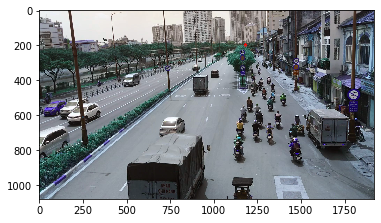

In [5]:
import cv2
from matplotlib import pyplot as plt
image = 'C:/Users/ADMINS/Desktop/Saigon/screen_2179.jpg'
img = cv2.imread(image)
img = cv2.circle(img, (1183,200), 6, (255,0,0), 5)
plt.imshow(img)

In [8]:
from vehicle_speed import *
# vp1 = [1.183030303030303e+03, 2.006060606060606e+02]
# vp2 = [-9.329230769230768e+03,9.338461538461538e+02]
vp1 = [1088,186]
vp2 = [-1021,238]
pp = [960, 540]
vp1, vp2, vp3, pp, roadPlane, focal = computeCameraCalibration(vp1,vp2,pp)
# print(pp)
p1 = np.array([1136,450,1])
p2 = np.array([818,440,1])
real = 10.5
p1 = getWorldCoordinagesOnRoadPlane(p1, focal, roadPlane, pp)
p2 = getWorldCoordinagesOnRoadPlane(p2, focal, roadPlane, pp)
print(type(p1))
print(p2)
fake = np.linalg.norm(p1-p2)
scale = real/fake
print(scale)
    
    

<class 'numpy.ndarray'>
[1291.39135336  773.3741925  -893.73479977]
0.0146239437857511


In [55]:
import cv2

img_path = "C:/Users/ADMINS/Desktop/SaiGon/screen_2179.jpg"
image = cv2.imread(img_path)
image

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [33]:
a = list(points)

In [63]:
vp1 = [144.737, 34.7794]
vp2 = [12183.582175112755, 615.451021479187]
pp = [960.5, 540.5]
vp1, vp2, vp3, pp, roadPlane, focal = tuple_cam
points = map(lambda p: np.array([p[-2],p[-1],1]), ([5,6],[7,8]))
print(list(points))
# points = map(projector, points)

# print(list(points))

[array([5, 6, 1]), array([7, 8, 1])]


In [5]:
from weakref import WeakValueDictionary

class Counter:
    _instances = WeakValueDictionary()
    @property
    def Count(self):
        return len(self._instances)

    def __init__(self, name):
        self.name = name
        self._instances[id(self)] = self
        print (name, 'created')

    def __del__(self):
        print (self.name, 'deleted')
        if self.Count == 0:
            print ('Last Counter object deleted')
        else:
            print (self.Count, 'Counter objects remaining')

x = Counter("First")

First created
First deleted
1 Counter objects remaining


In [15]:
!tf_upgrade_v2 --infile yolo_loading.py --outfile yolo_loading-update.py



INFO line 215:22: Added keywords to args of function 'tf.boolean_mask'
INFO line 216:27: Added keywords to args of function 'tf.boolean_mask'
INFO line 389:23: Added keywords to args of function 'tf.boolean_mask'
INFO line 411:19: Renamed 'tf.Print' to 'tf.compat.v1.Print'
TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 1 files
Detected 0 issues that require attention
--------------------------------------------------------------------------------


Make sure to read the detailed log 'report.txt'



2019-10-28 10:39:07.623482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll


In [21]:
import cv2
video_path = 'Z:\\Vehicle speed measuring\\video_speed measure\\front.avi'
import numpy as np
import cv2

cap = cv2.VideoCapture(video_path)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# Define the codec and create VideoWriter object
# fourcc = cv2.CV_FOURCC('m', 'p', '4', 'v') # upper case - yl3
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
out = cv2.VideoWriter("C:/Users/ADMINS/Desktop/tracking.avi", fourcc , 25, size, 1) #20.0: number of frames per sec

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
#         frame = cv2.flip(frame,1)

        # write the flipped frame
        out.write(frame)

        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

In [36]:
def checkFromTop(p, line):
    x,y = p
    x1 = 1199
    y1 = getY(x1, line)
    x2 = 507
    y2 = getY(x2, line)
    return (x-x1)*(y2-y1)-(y-y1)*(x2-x1) 
    
def getY(x, line):
    # ax + by + c =0
    a,b,c = line
    return (-a*x-c)/b 

print(checkFromTop([500,550],[-0.376, -1, +517.047]))



x,y = [30,450]
x1 =   507
y1 =    498
# b = x-x1 - (y-)
x2 =  1199
y2 =  472
a = (x-x1)*(y2-y1)-(y-y1)*(x2-x1)
print(a)

152899.476
45618


In [32]:
True and False and False

False